In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm
import numpy as np
from pandarallel import pandarallel
from scipy.stats import chi2_contingency, f_oneway, ttest_ind

tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
df = pd.read_pickle("../../data/esm_v1_embeddings_with_predictions.pkl")
df.head()

,VARIANTKEY,LABEL,ENSG,GENE_SYMBOL,AA_POSITION,PROTEIN_REF,PROTEIN_ALT,REF_EMBEDDING_ESM1v,ALT_EMBEDDING_ESM1v,LABEL_MAP,PREDICTION,PREDICTED_LABEL,COSINE_SIMILARITY,COSINE_DISTANCE
0,1-100196274-A-C,LOF,ENSG00000137992,DBT,477,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.023188237, 0.17757455, -0.08903169, 0.00287...",1,1,LOF,0.999989,0.000011
1,1-100196286-T-C,NEUTRAL,ENSG00000137992,DBT,473,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.017270943, 0.17832978, -0.089323506, -0.000...",0,1,LOF,0.999986,0.000014
2,1-100196349-T-C,LOF,ENSG00000137992,DBT,452,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.020151792, 0.18066218, -0.09096193, 0.00096...",1,1,LOF,0.999994,0.000006
3,1-100206470-G-A,LOF,ENSG00000137992,DBT,395,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.02822395, 0.17860094, -0.08821337, 0.002231...",1,1,LOF,0.999993,0.000007
4,1-100206621-C-T,LOF,ENSG00000137992,DBT,345,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.01695501, 0.17416799, -0.088790074, 0.00124...",1,1,LOF,0.999985,0.000015


In [4]:
print(classification_report(df["LABEL"], df["PREDICTED_LABEL"]))

              precision    recall  f1-score   support

         GOF       0.96      0.95      0.96      3137
         LOF       0.92      0.91      0.91     25376
     NEUTRAL       0.97      0.97      0.97     83924

    accuracy                           0.96    112437
   macro avg       0.95      0.94      0.95    112437
weighted avg       0.96      0.96      0.96    112437



/Users/victormaricato/mambaforge/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormaricato/mambaforge/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormaricato/mambaforge/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/victormaricato/

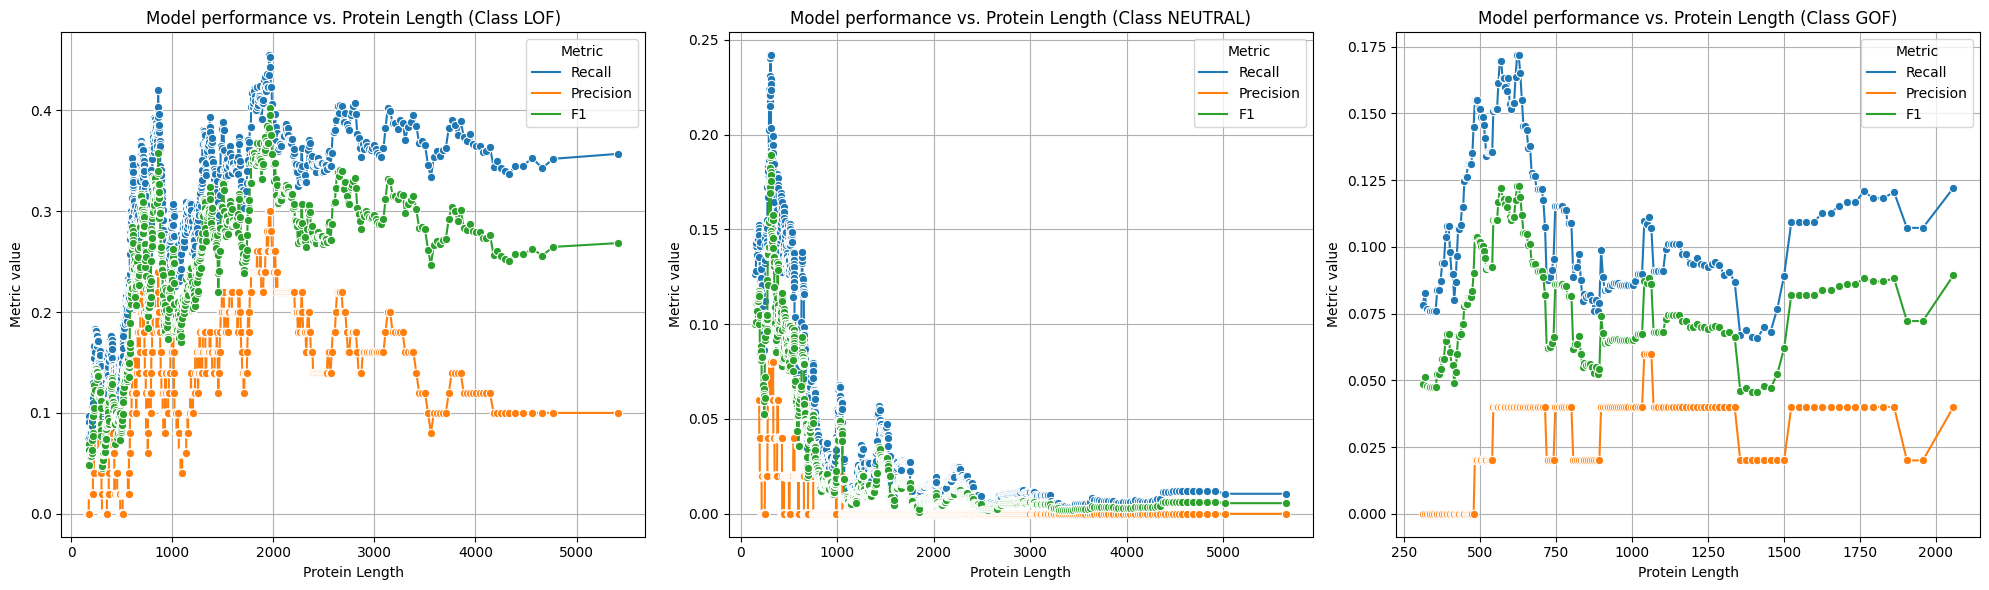

In [18]:
# Calculate the length of PROTEIN_ALT for each row
df['PROTEIN_ALT_LENGTH'] = df['PROTEIN_ALT'].apply(len)

# Get the unique classes
classes = df['LABEL'].unique()

# Create a figure with subplots for each class
fig, axes = plt.subplots(1, len(classes), figsize=(20, 6))

for i, class_label in enumerate(classes):
    # Filter the data for the current class
    class_data = df[df['LABEL'] == class_label]
    
    # Group the data by PROTEIN_ALT_LENGTH and calculate the error rates for each group
    error_rates = class_data.groupby('PROTEIN_ALT_LENGTH').apply(lambda x: pd.Series({
        'Recall': 1 - recall_score(x['LABEL'], x['PREDICTED_LABEL'], average='weighted'),
        'Precision': 1 - precision_score(x['LABEL'], x['PREDICTED_LABEL'], average='weighted'),
        'F1': 1 - f1_score(x['LABEL'], x['PREDICTED_LABEL'], average='weighted')
    }))
    
    # Reset the index to make PROTEIN_ALT_LENGTH a regular column
    error_rates.reset_index(inplace=True)
    
    # Apply a moving average to smooth the error rates
    window_size = 50
    error_rates = error_rates.rolling(window=window_size).mean()
    
    # Melt the DataFrame to convert recall, precision, and F1 columns into a single column
    error_rates_melted = pd.melt(error_rates, id_vars=['PROTEIN_ALT_LENGTH'], value_vars=['Recall', 'Precision', 'F1'], var_name='Metric', value_name='Error Rate')
    
    # Create a seaborn plot for the current class
    sns.lineplot(data=error_rates_melted, x='PROTEIN_ALT_LENGTH', y='Error Rate', hue='Metric', marker='o', ax=axes[i])
    axes[i].set_xlabel('Protein Length')
    axes[i].set_ylabel('Metric value')
    axes[i].set_title(f'Model performance vs. Protein Length (Class {class_label})')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
from scipy import stats

# Calculate the length of PROTEIN_ALT for each row
df['PROTEIN_ALT_LENGTH'] = df['PROTEIN_ALT'].apply(len)

# Create a new column indicating whether the prediction is correct or not
df['IS_CORRECT'] = (df['LABEL'] == df['PREDICTED_LABEL']).astype(int)

# Calculate the Spearman's rank correlation coefficient between protein length and prediction correctness
spearman_corr, p_value = stats.spearmanr(df['PROTEIN_ALT_LENGTH'], df['IS_CORRECT'])

print(f"Spearman's rank correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    if spearman_corr < 0:
        print("There is a significant negative correlation between protein length and prediction correctness.")
        print("Larger protein lengths are more difficult to predict.")
    else:
        print("There is a significant positive correlation between protein length and prediction correctness.")
        print("Larger protein lengths are easier to predict.")
else:
    print("There is no significant correlation between protein length and prediction correctness.")

Spearman's rank correlation coefficient: 0.0928
P-value: 0.0000
There is a significant positive correlation between protein length and prediction correctness.
Larger protein lengths are easier to predict.


In [10]:
AMINOACID_CLASSES = {
    "A": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "G": "Aliphatic",
    "V": "Aliphatic",
    "P": "Aliphatic",
    "F": "Aromatic",
    "W": "Aromatic",
    "Y": "Aromatic",
    "D": "Acidic",
    "E": "Acidic",
    "H": "Basic",
    "K": "Basic",
    "R": "Basic",
    "S": "Hydroxilic",
    "T": "Hydroxilic",
    "C": "Sulfur-containing",
    "M": "Sulfur-containing", 
    "N": "Amidic",
    "Q": "Amidic",
}

def get_aminoacid(protein: str, position: int) -> str:
    return protein[position - 1]


df["AMINOACID_REF"] = df.progress_apply(lambda x: get_aminoacid(x["PROTEIN_REF"], x["AA_POSITION"]), axis=1)
df["AMINOACID_ALT"] = df.progress_apply(lambda x: get_aminoacid(x["PROTEIN_ALT"], x["AA_POSITION"]), axis=1)
df["AMINOACID_REF_CLASS"] = df["AMINOACID_REF"].map(AMINOACID_CLASSES)
df["AMINOACID_ALT_CLASS"] = df["AMINOACID_ALT"].map(AMINOACID_CLASSES)
df["AMINOACID_CHANGE"] = df["AMINOACID_REF"] + "-" + df["AMINOACID_ALT"]
df["CLASS_CHANGE"] = df["AMINOACID_REF_CLASS"] + "-" + df["AMINOACID_ALT_CLASS"]

100%|██████████| 112437/112437 [00:00<00:00, 150878.62it/s]


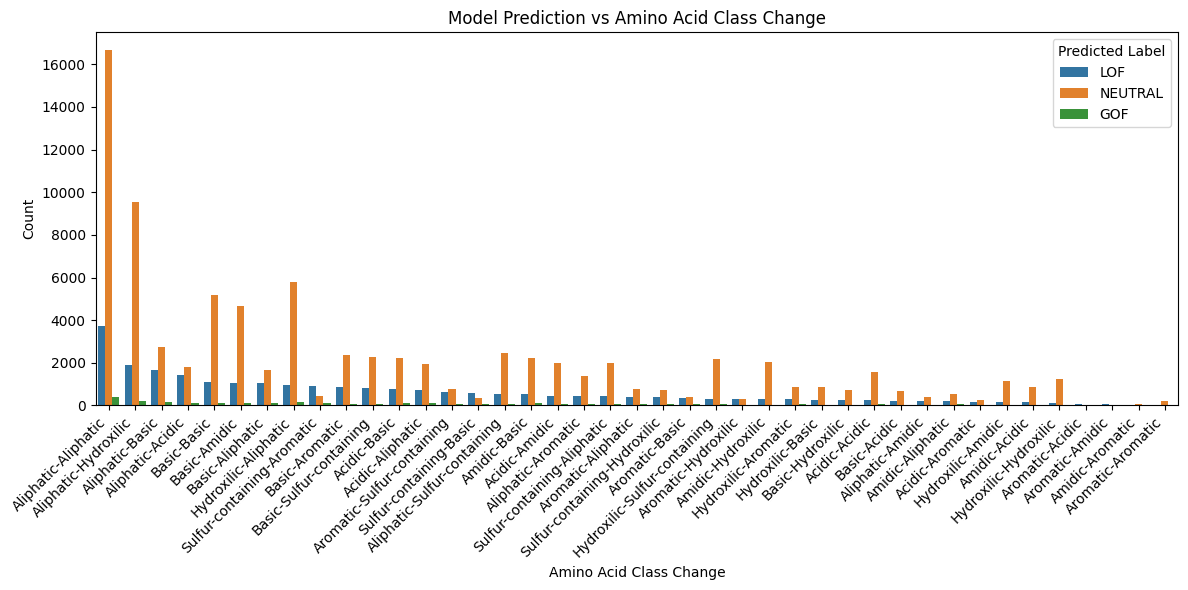

In [11]:
# Create a count plot of CLASS_CHANGE grouped by PREDICTED_LABEL
plt.figure(figsize=(12, 6))

# Count the occurrences of each CLASS_CHANGE and PREDICTED_LABEL combination
class_change_counts = df.groupby(["CLASS_CHANGE", "PREDICTED_LABEL"]).size().reset_index(name="count")

# Sort the class changes based on the count of "LOF" in descending order
sorted_class_changes = class_change_counts[class_change_counts["PREDICTED_LABEL"] == "LOF"].sort_values("count", ascending=False)["CLASS_CHANGE"].unique()

# Create the sorted count plot
sns.countplot(x="CLASS_CHANGE", hue="PREDICTED_LABEL", data=df, order=sorted_class_changes)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Amino Acid Class Change")
plt.ylabel("Count")
plt.title("Model Prediction vs Amino Acid Class Change")
plt.legend(title="Predicted Label", loc="upper right")
plt.tight_layout()
plt.show()

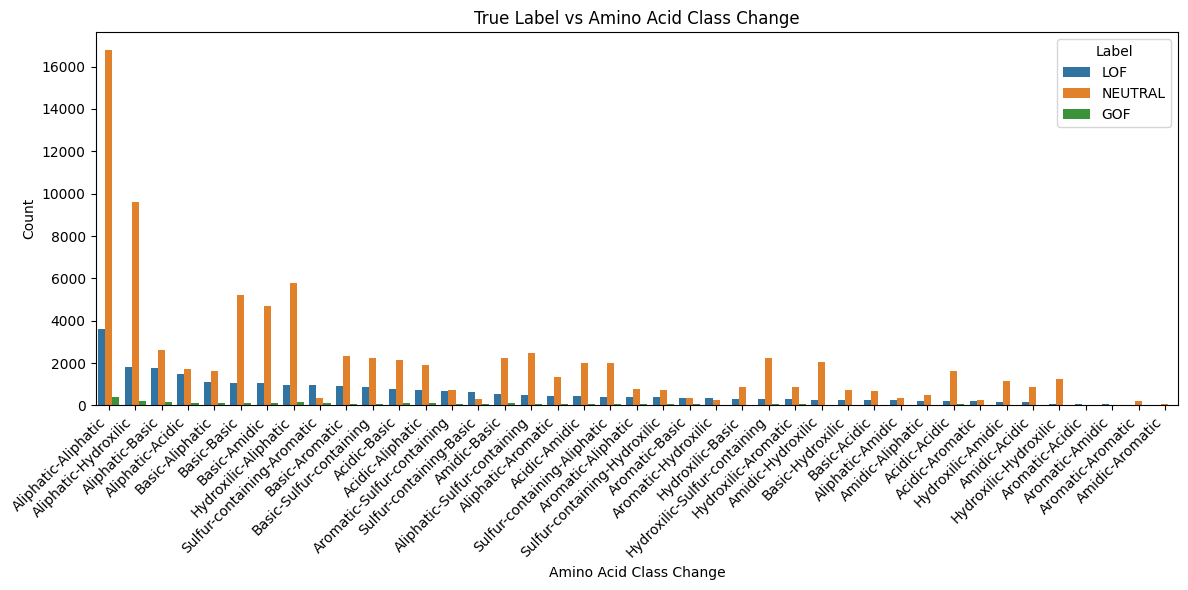

In [13]:
# Create a count plot of CLASS_CHANGE grouped by LABEL
plt.figure(figsize=(12, 6))

# Count the occurrences of each CLASS_CHANGE and LABEL combination
class_change_counts = df.groupby(["CLASS_CHANGE", "LABEL"]).size().reset_index(name="count")

# Sort the class changes based on the count of "LOF" in descending order
sorted_class_changes = class_change_counts[class_change_counts["LABEL"] == "LOF"].sort_values("count", ascending=False)["CLASS_CHANGE"].unique()

# Create the sorted count plot
sns.countplot(x="CLASS_CHANGE", hue="LABEL", data=df, order=sorted_class_changes)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Amino Acid Class Change")
plt.ylabel("Count")
plt.title("True Label vs Amino Acid Class Change")
plt.legend(title="Label", loc="upper right")
plt.tight_layout()
plt.show()

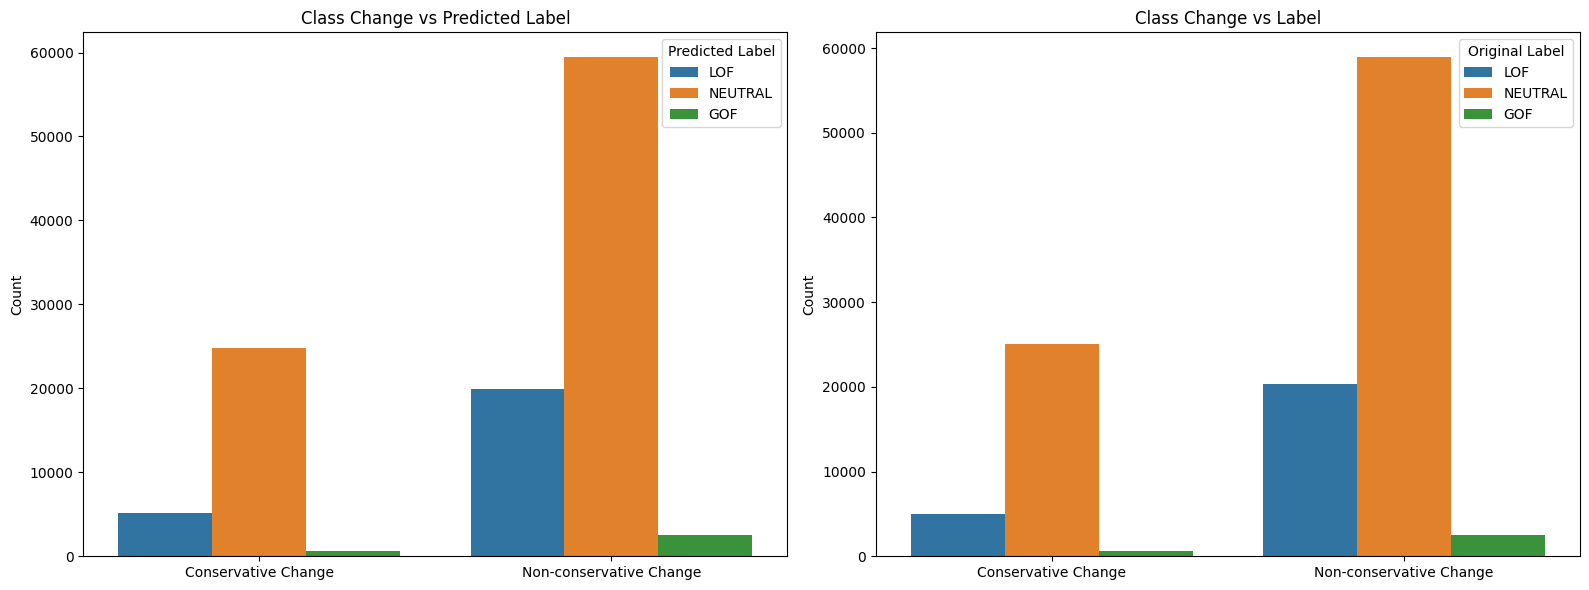

In [15]:
# Create a new column 'CLASS_CHANGED' indicating if the amino acid class changed
df['CLASS_CHANGED'] = (df['AMINOACID_REF_CLASS'] != df['AMINOACID_ALT_CLASS'])

# Create a new column 'LABEL_PREDICTED_MATCH' indicating if the original label matches the predicted label
df['LABEL_PREDICTED_MATCH'] = (df['LABEL'] == df['PREDICTED_LABEL'])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the count of CLASS_CHANGED grouped by PREDICTED_LABEL
sns.countplot(x='CLASS_CHANGED', hue='PREDICTED_LABEL', data=df, ax=ax1)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Conservative Change', 'Non-conservative Change'])
ax1.set_ylabel('Count')
ax1.set_title('Class Change vs Predicted Label')
ax1.legend(title='Predicted Label', loc='upper right')
ax1.set_xlabel('')

# Plot the count of LABEL_PREDICTED_MATCH grouped by LABEL
sns.countplot(x='CLASS_CHANGED', hue='LABEL', data=df, ax=ax2)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Conservative Change', 'Non-conservative Change'])
ax2.set_ylabel('Count')
ax2.set_title('Class Change vs Label')
ax2.legend(title='Original Label', loc='upper right')
ax2.set_xlabel('')

plt.tight_layout()
plt.show()

In [8]:
# Create contingency tables
contingency_label = pd.crosstab(df['CLASS_CHANGED'], df['LABEL'])
contingency_predicted = pd.crosstab(df['CLASS_CHANGED'], df['PREDICTED_LABEL'])

# Perform Chi-squared test for LABEL
chi2_label, p_label, _, _ = chi2_contingency(contingency_label)
print("Chi-squared test for LABEL:")
print("Chi-squared statistic:", chi2_label)
print("P-value:", p_label)

# Perform Chi-squared test for PREDICTED_LABEL
chi2_predicted, p_predicted, _, _ = chi2_contingency(contingency_predicted)
print("\nChi-squared test for PREDICTED_LABEL:")
print("Chi-squared statistic:", chi2_predicted)
print("P-value:", p_predicted)

Chi-squared test for LABEL:
Chi-squared statistic: 1114.9442144103841
P-value: 7.815198726157286e-243

Chi-squared test for PREDICTED_LABEL:
Chi-squared statistic: 857.8428469416922
P-value: 5.269781597213133e-187


In [9]:
df.head()

,VARIANTKEY,LABEL,ENSG,GENE_SYMBOL,AA_POSITION,PROTEIN_REF,PROTEIN_ALT,REF_EMBEDDING_ESM1v,ALT_EMBEDDING_ESM1v,LABEL_MAP,...,COSINE_SIMILARITY,COSINE_DISTANCE,AMINOACID_REF,AMINOACID_ALT,AMINOACID_REF_CLASS,AMINOACID_ALT_CLASS,AMINOACID_CHANGE,CLASS_CHANGE,CLASS_CHANGED,LABEL_PREDICTED_MATCH
0,1-100196274-A-C,LOF,ENSG00000137992,DBT,477,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.023188237, 0.17757455, -0.08903169, 0.00287...",1,...,0.999989,0.000011,M,R,Sulfur-containing,Basic,M-R,Sulfur-containing-Basic,True,True
1,1-100196286-T-C,NEUTRAL,ENSG00000137992,DBT,473,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.017270943, 0.17832978, -0.089323506, -0.000...",0,...,0.999986,0.000014,N,S,Amidic,Hydroxilic,N-S,Amidic-Hydroxilic,True,False
2,1-100196349-T-C,LOF,ENSG00000137992,DBT,452,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.020151792, 0.18066218, -0.09096193, 0.00096...",1,...,0.999994,0.000006,H,R,Basic,Basic,H-R,Basic-Basic,False,True
3,1-100206470-G-A,LOF,ENSG00000137992,DBT,395,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.02822395, 0.17860094, -0.08821337, 0.002231...",1,...,0.999993,0.000007,T,I,Hydroxilic,Aliphatic,T-I,Hydroxilic-Aliphatic,True,True
4,1-100206621-C-T,LOF,ENSG00000137992,DBT,345,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,MAAVRMLRTWSRNAGKLICVRYFQTCGNVHVLKPNYVCFFGYPSFK...,"[0.023711795, 0.17607689, -0.09241844, 0.00010...","[0.01695501, 0.17416799, -0.088790074, 0.00124...",1,...,0.999985,0.000015,G,R,Aliphatic,Basic,G-R,Aliphatic-Basic,True,True


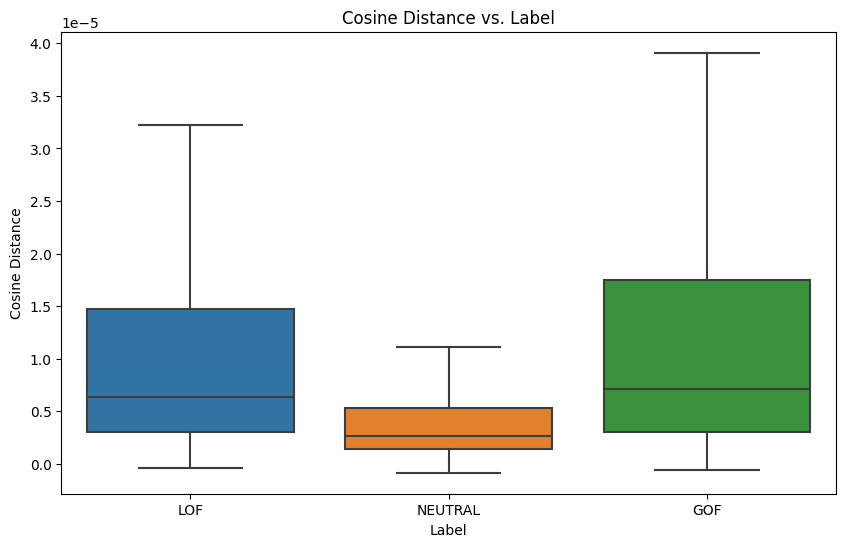

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='LABEL', y='COSINE_DISTANCE', data=df, showfliers=False)
plt.title("Cosine Distance vs. Label")
plt.xlabel("Label")
plt.ylabel("Cosine Distance")
plt.show()

In [11]:
# Separate the cosine similarity values based on the labels
neutral_cosine = df[df['LABEL'] == 'NEUTRAL']['COSINE_DISTANCE']
lof_cosine = df[df['LABEL'] == 'LOF']['COSINE_DISTANCE']
gof_cosine = df[df['LABEL'] == 'GOF']['COSINE_DISTANCE']

# Perform the one-way ANOVA test
f_statistic, p_value = f_oneway(neutral_cosine, lof_cosine, gof_cosine)

print("One-way ANOVA test results:")
print(f"F-statistic: {f_statistic:.3f}")
print(f"P-value: {p_value}")

One-way ANOVA test results:
F-statistic: 509.149
P-value: 7.494326462548962e-221


In [12]:
# Separate the cosine similarity values based on the labels
neutral_cosine = df[df['LABEL'] == 'NEUTRAL']['COSINE_DISTANCE']
lof_cosine = df[df['LABEL'] == 'LOF']['COSINE_DISTANCE']
gof_cosine = df[df['LABEL'] == 'GOF']['COSINE_DISTANCE']

# Perform independent t-tests
print("LOF vs. Neutral:")
t_stat, p_value = ttest_ind(lof_cosine, neutral_cosine)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

print("\nGOF vs. Neutral:")
t_stat, p_value = ttest_ind(gof_cosine, neutral_cosine)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

print("\nLOF vs. GOF:")
t_stat, p_value = ttest_ind(lof_cosine, gof_cosine)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value}")

LOF vs. Neutral:
T-statistic: 28.458
P-value: 1.7397412298807429e-177

GOF vs. Neutral:
T-statistic: 16.283
P-value: 1.5866649420020626e-59

LOF vs. GOF:
T-statistic: -7.457
P-value: 9.103780770431727e-14


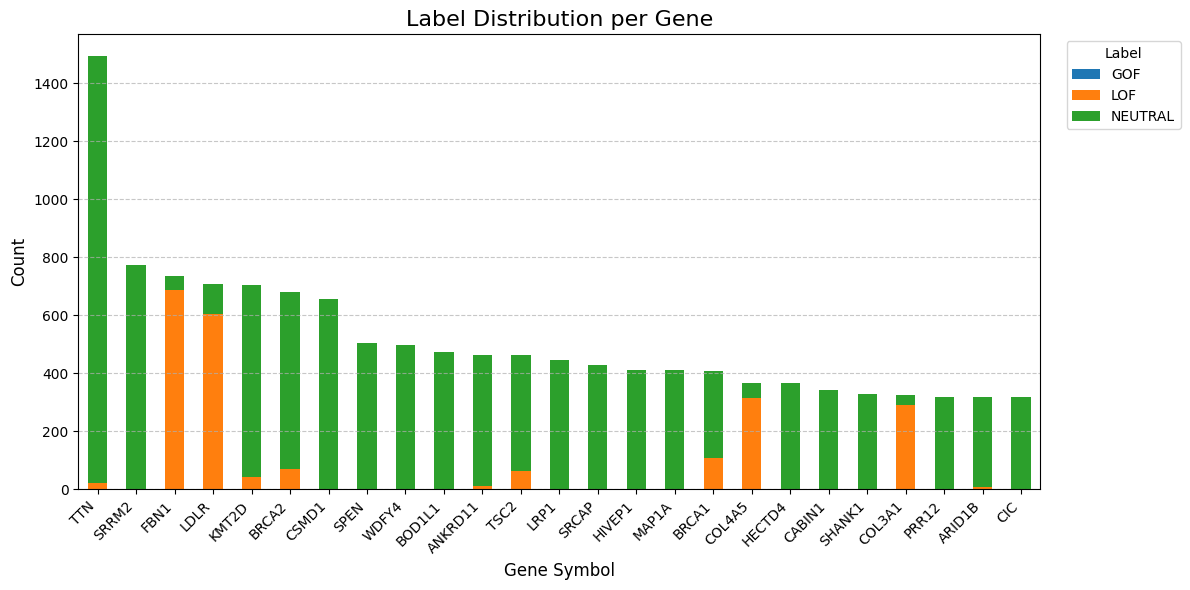

In [13]:
# Calculate the label counts for each gene
label_counts = df.groupby(['GENE_SYMBOL', 'LABEL']).size().unstack(fill_value=0)

# Sort the label counts by the total count for each gene
label_counts['Total'] = label_counts.sum(axis=1)
label_counts.sort_values('Total', ascending=False, inplace=True)
label_counts.drop('Total', axis=1, inplace=True)

label_counts = label_counts.head(25)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
label_counts.plot(kind='bar', stacked=True, ax=ax)
plt.title("Label Distribution per Gene", fontsize=16)
plt.xlabel("Gene Symbol", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Label", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

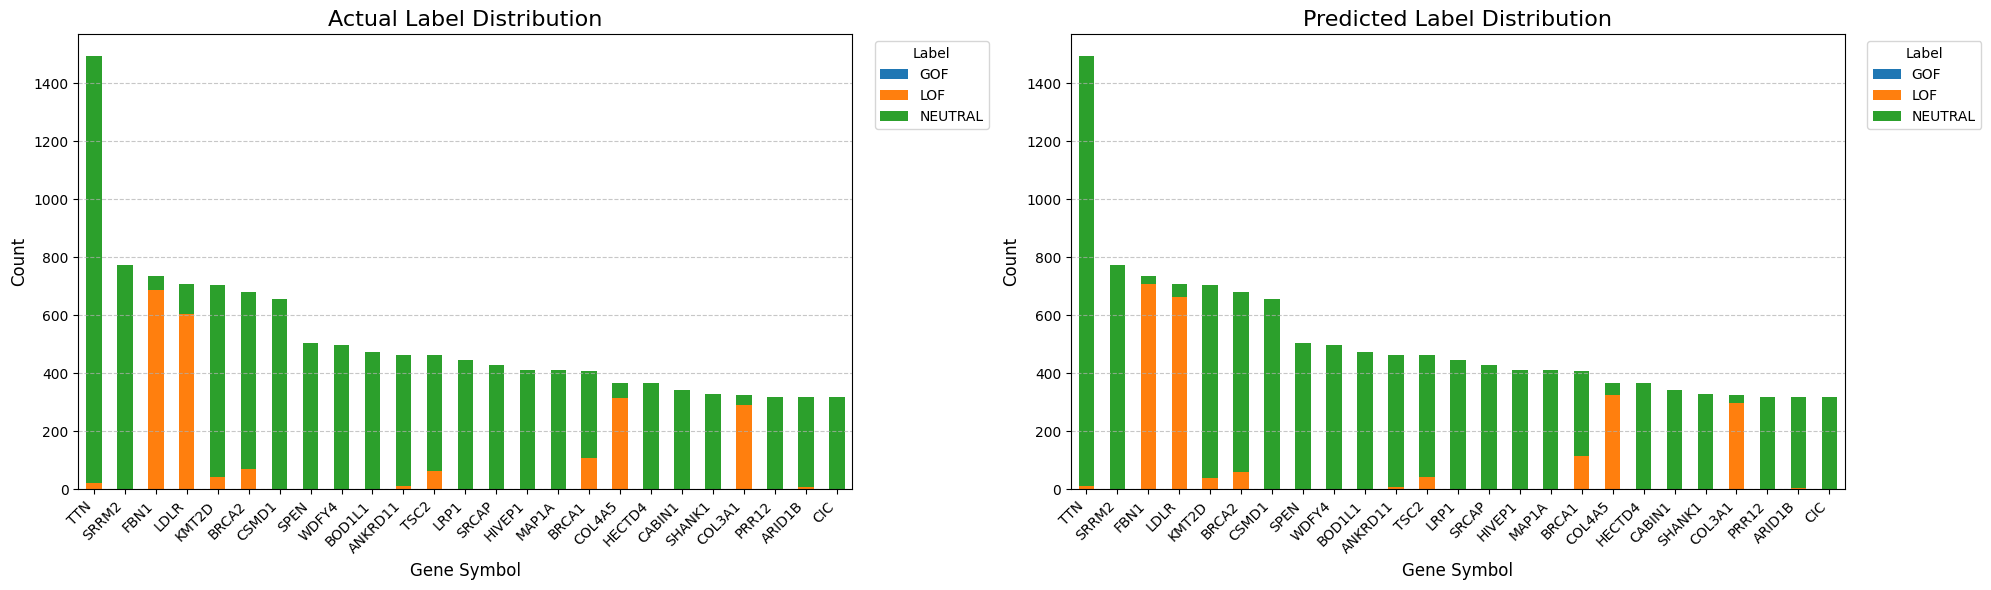

In [14]:
# Assuming you have already loaded the data into a pandas DataFrame called 'df'

# Calculate the actual label counts for each gene
actual_label_counts = df.groupby(['GENE_SYMBOL', 'LABEL']).size().unstack(fill_value=0)

# Calculate the predicted label counts for each gene
predicted_label_counts = df.groupby(['GENE_SYMBOL', 'PREDICTED_LABEL']).size().unstack(fill_value=0)

# Sort the label counts by the total count for each gene
actual_label_counts['Total'] = actual_label_counts.sum(axis=1)
predicted_label_counts['Total'] = predicted_label_counts.sum(axis=1)

actual_label_counts.sort_values('Total', ascending=False, inplace=True)
predicted_label_counts.sort_values('Total', ascending=False, inplace=True)

actual_label_counts.drop('Total', axis=1, inplace=True)
predicted_label_counts.drop('Total', axis=1, inplace=True)

# Select the top 25 genes
top_genes = actual_label_counts.head(25).index

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot the actual label distribution
actual_label_counts.loc[top_genes].plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title("Actual Label Distribution", fontsize=16)
ax1.set_xlabel("Gene Symbol", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_xticklabels(top_genes, rotation=45, ha='right')
ax1.legend(title="Label", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the predicted label distribution
predicted_label_counts.loc[top_genes].plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title("Predicted Label Distribution", fontsize=16)
ax2.set_xlabel("Gene Symbol", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_xticklabels(top_genes, rotation=45, ha='right')
ax2.legend(title="Label", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [15]:
# Create a confusion matrix for each gene
def calculate_metrics(gene):
    gene_df = df[df['GENE_SYMBOL'] == gene]
    y_true = gene_df['LABEL']
    y_pred = gene_df['PREDICTED_LABEL']
    
    labels = y_true.unique()
    metrics = {}
    
    for label in labels:
        precision = precision_score(y_true == label, y_pred == label, zero_division=0)
        recall = recall_score(y_true == label, y_pred == label, zero_division=0)
        f1 = f1_score(y_true == label, y_pred == label, zero_division=0)
        support = (y_true == label).sum()
        metrics[label] = {'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Support': support}
    
    return pd.DataFrame(metrics).T

# Calculate metrics for each gene
gene_metrics = {}
for gene in tqdm(df['GENE_SYMBOL'].unique()):
    gene_metrics[gene] = calculate_metrics(gene)

# Combine all gene metrics into a single DataFrame
metrics_df = pd.concat(gene_metrics, names=['Gene', 'Metric']).reset_index()

TOP_GENES = 25

# Find top 10 genes with the highest error for each label
top_error_genes = {}
for label in ['GOF', 'LOF', 'NEUTRAL']:
    top_error_genes[label] = metrics_df[metrics_df['Metric'] == label].sort_values('F1 Score').head(TOP_GENES)

# Display the top error genes for each label
for label, top_genes in top_error_genes.items():
    print(f"Top {TOP_GENES} Genes with Highest Error for {label}:")
    display(top_genes[['Gene', 'Precision', 'Recall', 'F1 Score', 'Support']])
    print()

100%|██████████| 2809/2809 [00:30<00:00, 90.75it/s]


Top 25 Genes with Highest Error for GOF:


,Gene,Precision,Recall,F1 Score,Support
969,ATP2A2,0.0,0.000000,0.000000,2.0
3786,IL31RA,0.0,0.000000,0.000000,1.0
3832,ADGRV1,0.0,0.000000,0.000000,1.0
182,CACNA1E,0.0,0.000000,0.000000,1.0
476,NFKB2,0.0,0.000000,0.000000,1.0
3436,ALPK1,0.0,0.000000,0.000000,1.0
3480,FGA,0.0,0.000000,0.000000,1.0
4459,PTDSS1,0.0,0.000000,0.000000,1.0
2084,SEPTIN9,0.0,0.000000,0.000000,2.0
157,F5,1.0,0.333333,0.500000,3.0



Top 25 Genes with Highest Error for LOF:


,Gene,Precision,Recall,F1 Score,Support
5061,TBL1Y,0.0,0.0,0.0,1.0
1513,KBTBD13,0.0,0.0,0.0,2.0
1515,CLPX,0.0,0.0,0.0,1.0
3090,SBF1,0.0,0.0,0.0,3.0
1529,KIF23,0.0,0.0,0.0,1.0
3080,FBLN1,0.0,0.0,0.0,1.0
710,SORL1,0.0,0.0,0.0,1.0
3076,TCF20,0.0,0.0,0.0,1.0
4202,PDE1C,0.0,0.0,0.0,1.0
4206,ANLN,0.0,0.0,0.0,1.0



Top 25 Genes with Highest Error for NEUTRAL:


,Gene,Precision,Recall,F1 Score,Support
1,DBT,0.0,0.0,0.0,5.0
2707,PPP1CB,0.0,0.0,0.0,1.0
522,ECHS1,0.0,0.0,0.0,1.0
4349,SLC52A2,0.0,0.0,0.0,2.0
1730,HSD11B2,0.0,0.0,0.0,1.0
4331,CYP11B1,0.0,0.0,0.0,8.0
1728,TK2,0.0,0.0,0.0,1.0
2725,CYP1B1,0.0,0.0,0.0,7.0
4308,EXT1,0.0,0.0,0.0,2.0
4294,RRM2B,0.0,0.0,0.0,1.0


In [16]:
# Calculate the percentage of genes with F1 score > 0.75 for each label
f1_threshold = 0.75
label_percentages = {}

for label in ['GOF', 'LOF', 'NEUTRAL']:
    label_metrics = metrics_df[metrics_df['Metric'] == label]
    total_genes = len(label_metrics)
    high_f1_genes = len(label_metrics[label_metrics['F1 Score'] > f1_threshold])
    percentage = (high_f1_genes / total_genes) * 100
    label_percentages[label] = percentage

# Display the percentage of genes with F1 score > 0.75 for each label
for label, percentage in label_percentages.items():
    print(f"Percentage of genes with F1 score > {f1_threshold} for {label}: {percentage:.2f}%")

Percentage of genes with F1 score > 0.75 for GOF: 87.31%
Percentage of genes with F1 score > 0.75 for LOF: 66.14%
Percentage of genes with F1 score > 0.75 for NEUTRAL: 87.17%


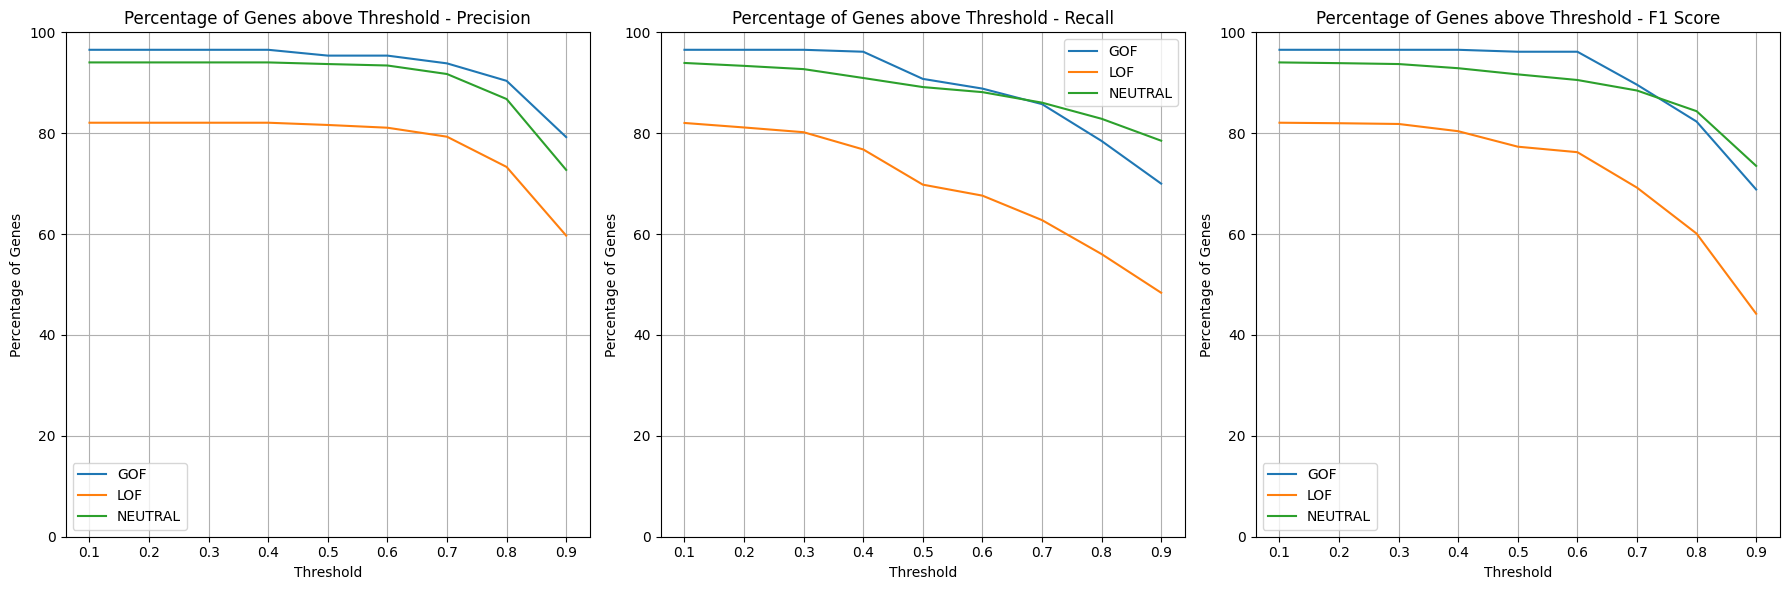

In [17]:
# Define the threshold range
thresholds = np.arange(0.1, 1.0, 0.1)

# Calculate the percentages for each metric and label across different thresholds
metric_percentages = {}

for metric in ['Precision', 'Recall', 'F1 Score']:
    metric_percentages[metric] = {}
    
    for label in ['GOF', 'LOF', 'NEUTRAL']:
        label_metrics = metrics_df[metrics_df['Metric'] == label]
        total_genes = len(label_metrics)
        
        percentages = []
        for threshold in thresholds:
            high_metric_genes = len(label_metrics[label_metrics[metric] > threshold])
            percentage = (high_metric_genes / total_genes) * 100
            percentages.append(percentage)
        
        metric_percentages[metric][label] = percentages

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(['Precision', 'Recall', 'F1 Score']):
    ax = axes[i]
    
    for label, percentages in metric_percentages[metric].items():
        ax.plot(thresholds, percentages, label=label)
    
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Percentage of Genes')
    ax.set_ylim(0, 100)
    ax.set_title(f'Percentage of Genes above Threshold - {metric}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [18]:
# Get the top 25 genes based on their counts
top_25_genes = df['GENE_SYMBOL'].value_counts().head(25).index

# Filter the metrics_df to include only the top 25 genes
top_25_metrics = metrics_df[metrics_df['Gene'].isin(top_25_genes)]

# Display the metrics for each of the top 25 genes
for gene in top_25_genes:
    print(f"Metrics for gene: {gene}")
    display(top_25_metrics[top_25_metrics['Gene'] == gene].set_index('Metric'))
    print()

Metrics for gene: TTN


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,TTN,0.992583,1.0,0.996277,1472.0
LOF,TTN,1.000000,0.5,0.666667,22.0



Metrics for gene: SRRM2


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,SRRM2,1.0,1.0,1.0,772.0



Metrics for gene: FBN1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
LOF,FBN1,0.968927,0.997093,0.982808,688.0
NEUTRAL,FBN1,0.928571,0.541667,0.684211,48.0



Metrics for gene: LDLR


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,LDLR,0.953488,0.398058,0.561644,103.0
LOF,LDLR,0.906767,0.996694,0.949606,605.0



Metrics for gene: KMT2D


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,KMT2D,0.988006,0.996974,0.992470,661.0
LOF,KMT2D,0.947368,0.818182,0.878049,44.0



Metrics for gene: BRCA2


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,BRCA2,0.977383,0.993432,0.985342,609.0
LOF,BRCA2,0.934426,0.802817,0.863636,71.0



Metrics for gene: CSMD1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,CSMD1,1.0,1.0,1.0,655.0



Metrics for gene: SPEN


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,SPEN,1.0,1.0,1.0,506.0



Metrics for gene: WDFY4


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,WDFY4,1.0,1.0,1.0,498.0



Metrics for gene: BOD1L1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,BOD1L1,1.0,1.0,1.0,473.0



Metrics for gene: ANKRD11


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
LOF,ANKRD11,1.000000,0.636364,0.777778,11.0
NEUTRAL,ANKRD11,0.991266,1.000000,0.995614,454.0



Metrics for gene: TSC2


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,TSC2,0.940476,0.989975,0.964591,399.0
LOF,TSC2,0.906977,0.609375,0.728972,64.0



Metrics for gene: LRP1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,LRP1,0.997758,1.0,0.998878,445.0
LOF,LRP1,0.000000,0.0,0.000000,1.0



Metrics for gene: SRCAP


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,SRCAP,1.0,1.0,1.0,429.0
LOF,SRCAP,1.0,1.0,1.0,1.0



Metrics for gene: HIVEP1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,HIVEP1,1.0,1.0,1.0,411.0



Metrics for gene: MAP1A


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,MAP1A,1.0,1.0,1.0,410.0



Metrics for gene: BRCA1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,BRCA1,0.979522,0.959866,0.969595,299.0
LOF,BRCA1,0.894737,0.944444,0.918919,108.0



Metrics for gene: COL4A5


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
LOF,COL4A5,0.957187,0.993651,0.975078,315.0
NEUTRAL,COL4A5,0.950000,0.730769,0.826087,52.0



Metrics for gene: HECTD4


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,HECTD4,1.0,1.0,1.0,366.0



Metrics for gene: CABIN1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,CABIN1,1.0,1.0,1.0,342.0



Metrics for gene: SHANK1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,SHANK1,1.0,1.0,1.0,330.0



Metrics for gene: COL3A1


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,COL3A1,0.884615,0.676471,0.766667,34.0
LOF,COL3A1,0.963211,0.989691,0.976271,291.0



Metrics for gene: PRR12


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,PRR12,1.0,1.0,1.0,320.0



Metrics for gene: ARID1B


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,ARID1B,0.987302,1.0,0.993610,311.0
LOF,ARID1B,1.000000,0.5,0.666667,8.0



Metrics for gene: CIC


,Gene,Precision,Recall,F1 Score,Support
Metric,,,,,
NEUTRAL,CIC,0.996845,1.000000,0.99842,316.0
LOF,CIC,1.000000,0.666667,0.80000,3.0


The differences in the model's performance for predicting LOF and GOF using ESM model embeddings for the two groups of genes you provided can be attributed to several biological factors. Let's discuss some possible explanations:

**Gene function and domain knowledge:**

The genes that are well-understood by the model, such as TTN, FBN1, LDLR, BRCA1, and BRCA2, are associated with well-characterized genetic disorders or have well-established roles in cellular processes. For example, BRCA1 and BRCA2 are known tumor suppressor genes involved in DNA repair and are associated with hereditary breast and ovarian cancer.
On the other hand, the genes that are not well-understood by the model, such as SLC25A24, SMARCD1, and CCND2, may have less established or more complex roles in cellular processes, making it harder for the model to predict their impact based on the ESM embeddings alone.

**Training data and model limitations:**

The performance of the model also depends on the quality and quantity of the training data used to train the ESM embeddings. If the training data is biased towards certain well-studied genes or variant types, the model may perform better on those genes compared to less represented or studied genes.
Additionally, the ESM embeddings capture certain aspects of protein structure and function, but they may not capture all the relevant biological information needed to predict the impact of variants accurately for all genes. The model's limitations and the choice of embedding representation can affect its performance on different gene sets.


**Biological complexity and epistasis:**

Some genes may have more complex interactions with other genes or be influenced by epistatic effects, where the impact of a variant depends on the presence of other variants or genetic background. These complex interactions may not be well-captured by the ESM embeddings alone, leading to poorer performance on certain genes.
The genes that are not well-understood by the model may be part of less studied pathways or have more intricate relationships with other cellular components, making it harder to predict their variant effects based on the embeddings.


**Let's dive into the biological roles and functions of the genes you mentioned: SLC25A24, SMARCD1, and CCND2.**

**SLC25A24 (Solute Carrier Family 25 Member 24):**

SLC25A24 is a member of the mitochondrial carrier family, which is involved in the transport of various metabolites across the inner mitochondrial membrane.
It is known to transport ATP-Mg/Pi, playing a role in the regulation of mitochondrial energy metabolism and adenine nucleotide translocation.
Mutations in SLC25A24 have been associated with a rare genetic disorder called Fontaine progeroid syndrome, which is characterized by premature aging, short stature, and distinct facial features.
However, the exact mechanisms by which SLC25A24 mutations lead to the disease phenotype and its broader role in cellular processes are not fully understood.

**SMARCD1 (SWI/SNF Related, Matrix Associated, Actin Dependent Regulator of Chromatin, Subfamily D, Member 1):**

SMARCD1 is a subunit of the SWI/SNF chromatin remodeling complex, which plays a crucial role in regulating gene expression by altering chromatin structure.
The SWI/SNF complex is involved in various cellular processes, including transcriptional regulation, cell cycle control, and DNA repair.
SMARCD1 is thought to contribute to the stability and activity of the SWI/SNF complex, but its specific functions and interactions within the complex are not fully elucidated.
Mutations in other subunits of the SWI/SNF complex have been implicated in various cancers and developmental disorders, highlighting the importance of this complex in cellular processes. However, the specific role of SMARCD1 in disease pathogenesis remains to be clarified.


**CCND2 (Cyclin D2):**

CCND2 is a member of the cyclin family, which are key regulators of the cell cycle progression.
Cyclins, including CCND2, form complexes with cyclin-dependent kinases (CDKs) to control the transition between different phases of the cell cycle.
CCND2 specifically interacts with CDK4 and CDK6 to regulate the G1/S transition, promoting cell cycle progression and cell proliferation.
Dysregulation of CCND2 has been implicated in various cancers, such as leukemia and breast cancer, where its overexpression can contribute to uncontrolled cell growth.
However, the precise mechanisms by which CCND2 dysregulation leads to cancer development and its interplay with other cell cycle regulators are still being investigated.
These genes are involved in important cellular processes, such as mitochondrial metabolism (SLC25A24), chromatin remodeling (SMARCD1), and cell cycle regulation (CCND2). However, their exact functions, interactions, and disease associations are not as well-characterized as some other genes. This lack of comprehensive understanding may contribute to the difficulty in predicting the impact of variants in these genes based on the ESM embeddings alone.
